In [1]:
!pip install tabulate

In [2]:
# Tensorflow
import tensorflow as tf
print(tf.__version__)

# I/O libraries
import os

# Helper libraries
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
from sklearn.metrics import confusion_matrix
from tabulate import tabulate



1.15.0


# Label list
| class | category | train id |
|-------|----------|----------|
| road | flat | 0 |
| sidewalk | flat | 1 |
| building | construction | 2 |
| wall | construction | 3 |
| fence | construction | 4 |
| pole | object | 5 |
| traffic light | object | 6 |
| traffic sign | object | 7 |
|vegetation| nature | 8 | 
|terrain|  nature | 9 |
|sky|      sky| 10 |  
|person| human | 11 |
|rider| human | 12 |
|car| vehicle | 13 |
|truck|vehicle| 14 |
|bus| vehicle | 15 |
|train|   vehicle| 16 |
|motorcycle| vehicle | 17 |
|bicycle| vehicle | 18 |

Note: 
Not all classes appear in the dataset. For driving scenes, we only consider the following classes:
0=>road, 1=>sidewalk, 2,3,4=>building, 5=>pole, 6=>traffic light, 7=>traffic sign,8=>vegetation, 
9=>terrain, 11,12=>person, 13,14,15=>car

# Util functions to visualize seg map.

In [57]:
def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)
LABELS_TO_COMP = [0,1,2,5,6,7,8,9,11,13]

In [75]:

def vis_segmentation(image, pred_seg_map, gt_seg_map):
    """Visualizes input image, predicted/ground-truth segmentation maps and their overlay views."""
    plt.figure(figsize=(20, 8))
    grid_spec = gridspec.GridSpec(2, 3, width_ratios=[6, 6, 6])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    pred_seg_map = label_to_color_image(pred_seg_map).astype(np.uint8)
    plt.imshow(pred_seg_map)
    plt.axis('off')
    plt.title('predicted segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(pred_seg_map, alpha=0.7)
    plt.axis('off')
    plt.title('predicted segmentation overlay')

    plt.subplot(grid_spec[4])
    gt_seg_map = label_to_color_image(gt_seg_map).astype(np.uint8)
    plt.imshow(gt_seg_map)
    plt.axis('off')
    plt.title('ground-truth segmentation map')

    plt.subplot(grid_spec[5])
    plt.imshow(image)
    plt.imshow(gt_seg_map, alpha=0.7)
    plt.axis('off')
    plt.title('ground-truth segmentation overlay')
    
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[LABELS_TO_COMP].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(LABELS_TO_COMP)), LABEL_NAMES[LABELS_TO_COMP])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

# Working directories

In [90]:
pred_dir = '/home/ubuntu/cs230/data/bdd100k/hrnet_output_id20/'
gt_dir = '/home/ubuntu/cs230/data/bdd100k/seg/labels/train_id20/'
raw_img_dir = '/home/ubuntu/cs230/data/bdd100k/video_images/train/'

In [92]:
img_name_list = [f for f in os.listdir(raw_img_dir) 
                 if (os.path.isdir(os.path.join(raw_img_dir, f)) and f != 'resize')]
print('number of images to compare: ' , len(img_name_list))

number of images to compare:  435


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


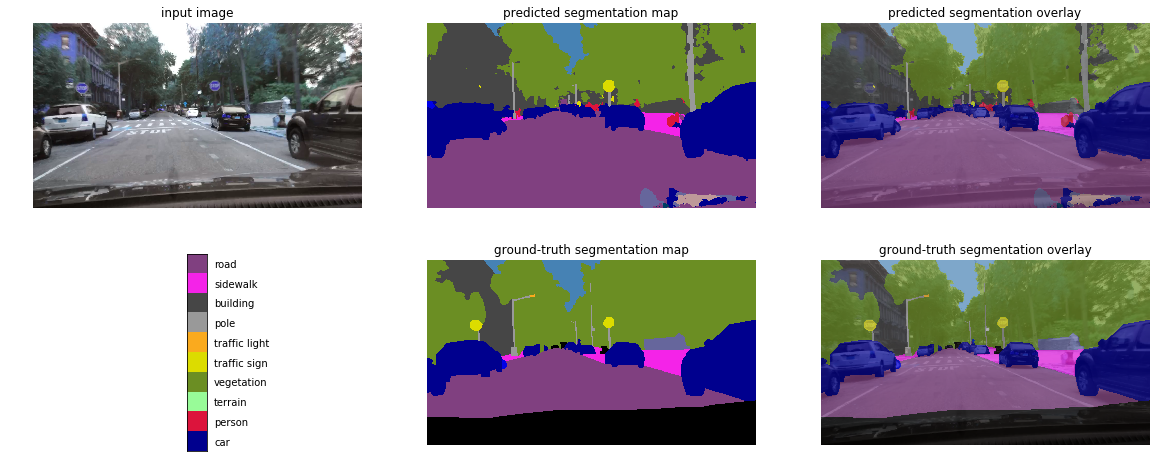

In [93]:
# Plot first sample image
img_name = img_name_list[0]
pred_path = os.path.join(pred_dir, img_name+'_1000.png')
gt_path = os.path.join(gt_dir, img_name+'_train_id.png')
img_path = os.path.join(raw_img_dir, img_name, img_name+'_1000.png')

raw_image = cv.imread(img_path)
pred_seg_map = cv.imread(pred_path, cv.IMREAD_GRAYSCALE)
gt_seg_map = cv.imread(gt_path, cv.IMREAD_GRAYSCALE)

vis_segmentation(raw_image, pred_seg_map, gt_seg_map)

# Evaluate on the segmented image
There are many ways to measure the performance of a segmentation model. The most straight forward one is pixel accuracy, which calculates how many pixels are correctly predicted. Another commonly used one is the standard Jaccard Index (intersection-over-union) as IoU = TP ⁄ (TP+FP+FN), where TP, FP, and FN are the numbers of true positive, false positive, and false negative pixels, respectively.

In [102]:
def compute_IoU(cm):
    """
    compute IoU (both mean and per class metric).
    cm: confusion_maxtrix
    """
    intersection = np.diag(cm) # tp
    union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm) # pos + res - tp
    class_iou = np.round(intersection / union, 5)
    return class_iou


def evaluate_single(seg_map, ground_truth):
    """Evaluate a single frame."""    
    # merge label due to different annotation scheme
    seg_map[np.logical_or(seg_map==14,seg_map==15)] = 13
    seg_map[np.logical_or(seg_map==3,seg_map==4)] = 2
    seg_map[seg_map==12] = 11

    # calculate accuracy on valid area
    acc = np.sum(seg_map[ground_truth!=19]==ground_truth[ground_truth!=19])/np.sum(ground_truth!=19)
    
    # select valid labels for evaluation
    cm = confusion_matrix(ground_truth[ground_truth!=19], seg_map[ground_truth!=19], 
                          labels=np.array(LABELS_TO_COMP))
    return acc, cm


def evaluate_batch(img_name_list, pred_dir, gt_dir):
    accs = []
    cm_cum = np.zeros((len(LABELS_TO_COMP), len(LABELS_TO_COMP)))
    for count, img_name in enumerate(img_name_list,1):
        pred_path = os.path.join(pred_dir, img_name+'_1000.png')
        gt_path = os.path.join(gt_dir, img_name+'_train_id.png')

        if count % 25 == 0: 
            print("finished ", count, " out of ", len(img_name_list))
            print("compare: ", img_name)
        pred_seg_map = cv.imread(pred_path, cv.IMREAD_GRAYSCALE)
        gt_seg_map = cv.imread(gt_path, cv.IMREAD_GRAYSCALE)
        acc, cm = evaluate_single(pred_seg_map, gt_seg_map)
        accs.append(acc)
        cm_cum += cm
    mean_acc = np.mean(accs)
    class_iou = compute_IoU(cm_cum)
    print('pixel accuracy: %.5f'%mean_acc)
    print('mean class IoU: %.5f', np.nanmean(class_iou))
    print('class IoU:')
    print(tabulate([class_iou], headers=LABEL_NAMES[LABELS_TO_COMP]))
    return mean_acc, class_iou

In [ ]:
evaluate_batch(img_name_list, pred_dir, gt_dir)

finished  25  out of  435
compare:  07034b4f-2ffea8e6
finished  50  out of  435
compare:  0fc07ccd-14991933
finished  75  out of  435
compare:  196fd10e-21e3fbdf
finished  100  out of  435
compare:  075d2e1d-971a3fea
finished  125  out of  435
compare:  02133057-fc70cc0e
finished  150  out of  435
compare:  10c0c72d-dafc19cf
finished  175  out of  435
compare:  196d16dd-e26c2301
finished  200  out of  435
compare:  07434289-7c2e8f71
finished  225  out of  435
compare:  1710645f-b36fa2e7
finished  250  out of  435
compare:  0c04d29a-6bf85baf
finished  275  out of  435
compare:  07398e6d-65825072
finished  300  out of  435
compare:  0cf398b3-ce65ab64
